In [1]:
# Public Schools Virtual/Magnet/Year Round Analysis and Cross-Validated Random Forest with Year Interactions

import sqlite3
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

__file__ = %pwd
DATA = Path(__file__).parent.parent / "data"
PRIORITIES = DATA / "Priorities"
DATABASE = DATA / "databases" / "exploration.db"

import sys
sys.path.append(str(DATA.parent))  # Add the parent directory of 'modeling' to the Python path

from modeling.utils.randomforest import (
    cross_validate_random_forest,
    train_random_forest_model,
    plot_cv_feature_importance_rf,
    plot_top_k_features_rf,
    plot_feature_avg_variance_rf,
    plot_feature_time_series_rf,
)

con = sqlite3.connect(DATABASE)
cur = con.cursor()

In [2]:
# Get tables
census_day = pd.read_sql_query("SELECT * FROM CensusDayWide", con)
acgr = pd.read_sql_query("SELECT * FROM ACGRWide", con)
public_schools = pd.read_sql_query("SELECT * FROM PublicSchools", con)

# Let's check what columns we have in public_schools related to school types
special_school_types = ["Virtual", "Magnet", "YearRound", "Multilingual"]
special_cols = [
    col
    for col in public_schools.columns
    if any(type_name in col for type_name in special_school_types)
]
print(f"Special school type columns: {special_cols}")

# Filter to get only these columns plus SchoolCode for joining
public_schools_filtered = public_schools[["SchoolCode"] + special_cols]

# Reduce columns from other tables
census_day_reduced = census_day.drop(
    columns=["AggregateLevel", "DistrictCode", "CountyCode"], errors="ignore"
)
acgr_reduced = acgr.drop(columns=["DistrictCode", "CountyCode"], errors="ignore")

# Merge DataFrames including public_schools_filtered
merged = census_day_reduced.merge(acgr_reduced, on="SchoolCode", how="inner")
merged = merged.merge(public_schools_filtered, on="SchoolCode", how="left")

# Fill NAs in special school type columns with 'N' (assuming missing means not that type)
for col in special_cols:
    merged[col] = merged[col].fillna("N")

# Convert to numeric values
for col in merged.columns:
    if any(substr in col for substr in ["Rate", "Percent", "ENR", "GR_"]):
        merged[col] = pd.to_numeric(merged[col], errors="coerce")

# Create year-based dataframes
academic_years = [
    "2017-18",
    "2018-19",
    "2019-20",
    "2020-21",
    "2021-22",
    "2022-23",
    "2023-24",
]

columns_to_drop = [
    col
    for col in merged.columns
    if col.startswith("RegHSDiploma")
    or col.startswith("Dropout")
    or col.startswith("UniReqs")
    or col.startswith("Other")
    or col.startswith("GR_")
]


def filter_academic_year(df, year):
    """Filter dataframe by academic year and drop AcademicYear column"""
    filtered_df = df[df["AcademicYear"] == year].copy()
    return filtered_df.drop(columns=["AcademicYear"])


year_df_mapping = {year: filter_academic_year(merged, year) for year in academic_years}

Special school type columns: ['Virtual', 'Magnet', 'YearRound', 'Multilingual']


In [3]:
# Part 1: Analyze special school types for the most recent year (2023-24 or 2022-23)
# Let's use the most recent year with complete data

latest_year = academic_years[-1]  # Assuming the last year in the list is the most recent
df_latest = year_df_mapping[latest_year]

# Create dummies for analysis 
for col in special_cols:
    df_latest[f"{col}_dummy"] = (df_latest[col] == 'Y').astype(int)

# Analyze each special school type
print(f"Analysis of special school types in {latest_year}:\n")
for school_type in special_cols:
    schools_of_type = df_latest[df_latest[school_type] == 'Y']
    other_schools = df_latest[df_latest[school_type] != 'Y']
    
    if len(schools_of_type) > 0:
        print(f"{school_type} schools count: {len(schools_of_type)}")
        
        # Graduation rate comparison
        grad_rate_type = schools_of_type["RegHSDiplomaRate.TA"].mean()
        grad_rate_other = other_schools["RegHSDiplomaRate.TA"].mean()
        print(f"  Average graduation rate for {school_type} schools: {grad_rate_type:.2f}%")
        print(f"  Average graduation rate for non-{school_type} schools: {grad_rate_other:.2f}%")
        print(f"  Difference: {grad_rate_type - grad_rate_other:.2f}%")
        
        # College readiness comparison
        college_ready_type = schools_of_type["UniReqsPercent.TA"].mean()
        college_ready_other = other_schools["UniReqsPercent.TA"].mean()
        print(f"  Average college readiness for {school_type} schools: {college_ready_type:.2f}%")
        print(f"  Average college readiness for non-{school_type} schools: {college_ready_other:.2f}%")
        print(f"  Difference: {college_ready_type - college_ready_other:.2f}%\n")

Analysis of special school types in 2023-24:

Magnet schools count: 1098
  Average graduation rate for Magnet schools: 91.61%
  Average graduation rate for non-Magnet schools: 90.16%
  Difference: 1.45%
  Average college readiness for Magnet schools: 58.69%
  Average college readiness for non-Magnet schools: 47.32%
  Difference: 11.38%

YearRound schools count: 690
  Average graduation rate for YearRound schools: 90.35%
  Average graduation rate for non-YearRound schools: 90.32%
  Difference: 0.03%
  Average college readiness for YearRound schools: 46.73%
  Average college readiness for non-YearRound schools: 48.66%
  Difference: -1.93%

Multilingual schools count: 1108
  Average graduation rate for Multilingual schools: 90.67%
  Average graduation rate for non-Multilingual schools: 90.28%
  Difference: 0.39%
  Average college readiness for Multilingual schools: 51.57%
  Average college readiness for non-Multilingual schools: 48.16%
  Difference: 3.41%



Analysis of Pre-COVID vs Post-COVID periods:

RegHSDiplomaRate.TA:
  Pre-COVID average: 90.38%
  Post-COVID average: 90.35%
  Difference: -0.04%

UniReqsPercent.TA:
  Pre-COVID average: 48.67%
  Post-COVID average: 48.52%
  Difference: -0.15%



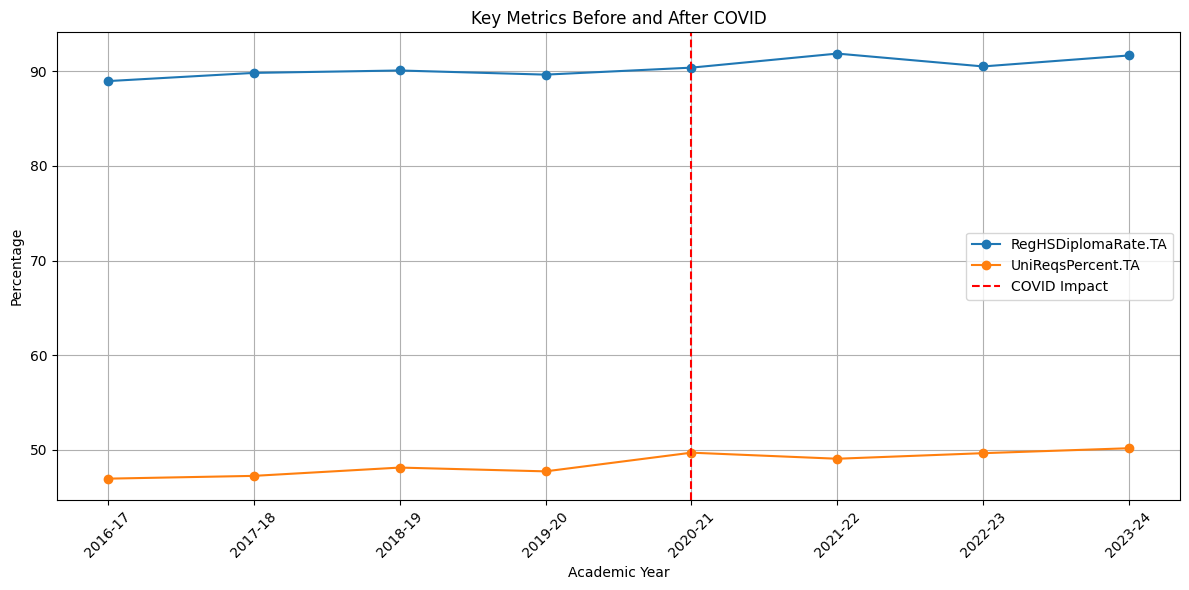

In [4]:
# Part 2: Test Scores Missing in 2020-21
# Let's analyze pre-COVID vs post-COVID periods

# Define pre and post COVID periods
pre_covid_years = ["2017-18", "2018-19", "2019-20"]
post_covid_years = ["2021-22", "2022-23", "2023-24"]

# Create combined datasets
pre_covid_df = pd.concat([year_df_mapping[year] for year in pre_covid_years])
pre_covid_df["Period"] = "Pre-COVID"
pre_covid_df["Year_Numeric"] = pre_covid_df["Year"].apply(lambda x: int(x.split("-")[0]))

post_covid_df = pd.concat([year_df_mapping[year] for year in post_covid_years])
post_covid_df["Period"] = "Post-COVID"
post_covid_df["Year_Numeric"] = post_covid_df["Year"].apply(lambda x: int(x.split("-")[0]))

# Combine both periods
combined_covid_df = pd.concat([pre_covid_df, post_covid_df])

# Add interaction with Period
combined_covid_df["Period_Numeric"] = (combined_covid_df["Period"] == "Post-COVID").astype(int)

# Analyze differences
print("Analysis of Pre-COVID vs Post-COVID periods:\n")
metrics = ["RegHSDiplomaRate.TA", "UniReqsPercent.TA"]

for metric in metrics:
    pre_mean = pre_covid_df[metric].mean()
    post_mean = post_covid_df[metric].mean()
    
    print(f"{metric}:")
    print(f"  Pre-COVID average: {pre_mean:.2f}%")
    print(f"  Post-COVID average: {post_mean:.2f}%")
    print(f"  Difference: {post_mean - pre_mean:.2f}%\n")

# Plot trends
plt.figure(figsize=(12, 6))
for metric in metrics:
    yearly_means = combined_covid_df.groupby("Year")[metric].mean()
    plt.plot(yearly_means.index, yearly_means.values, marker='o', label=metric)

plt.axvline(x="2020-21", color='r', linestyle='--', label="COVID Impact")
plt.title("Key Metrics Before and After COVID")
plt.xlabel("Academic Year")
plt.ylabel("Percentage")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Cross-validated Random Forest for RegHSDiplomaRate.TA (All Years Combined)

Random Forest Regression Results for RegHSDiplomaRate.TA:
RMSE: 1.7384
MSE: 3.0219
R²: 0.9793


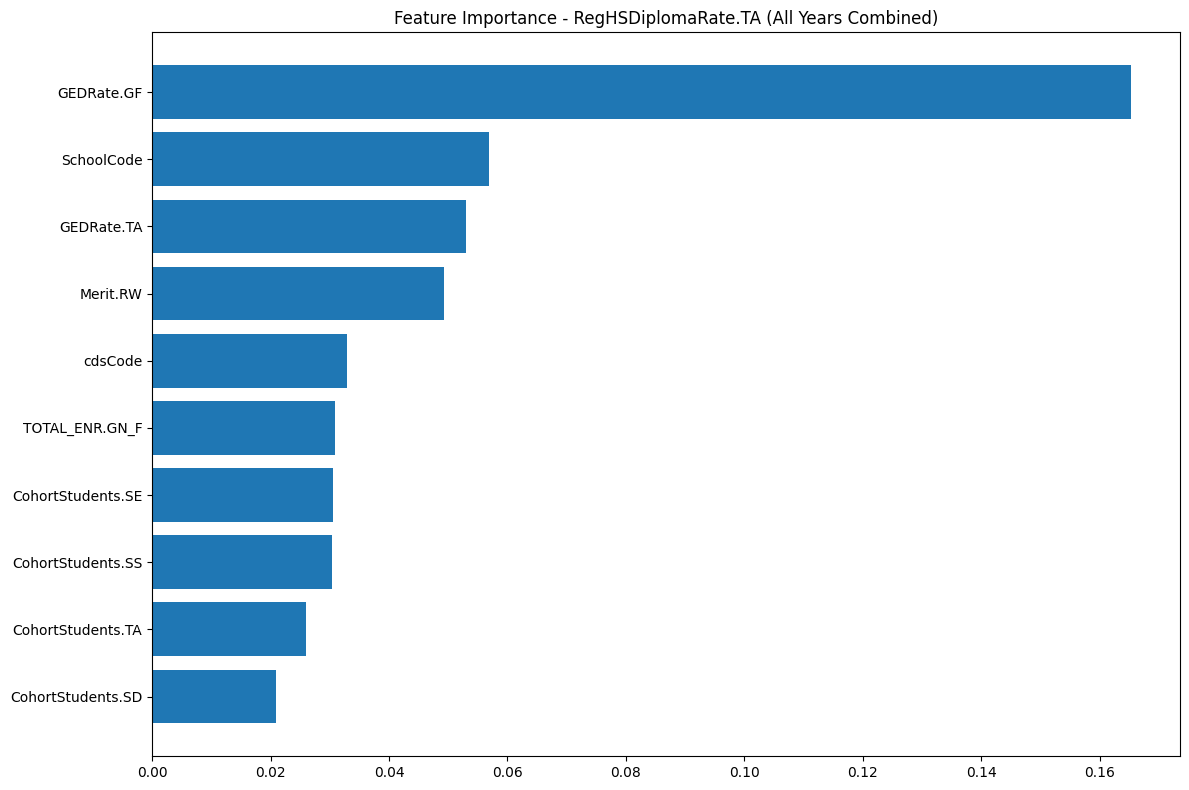


Cross-validated Random Forest for UniReqsPercent.TA (All Years Combined)

Random Forest Regression Results for UniReqsPercent.TA:
RMSE: 2.8044
MSE: 7.8649
R²: 0.9845


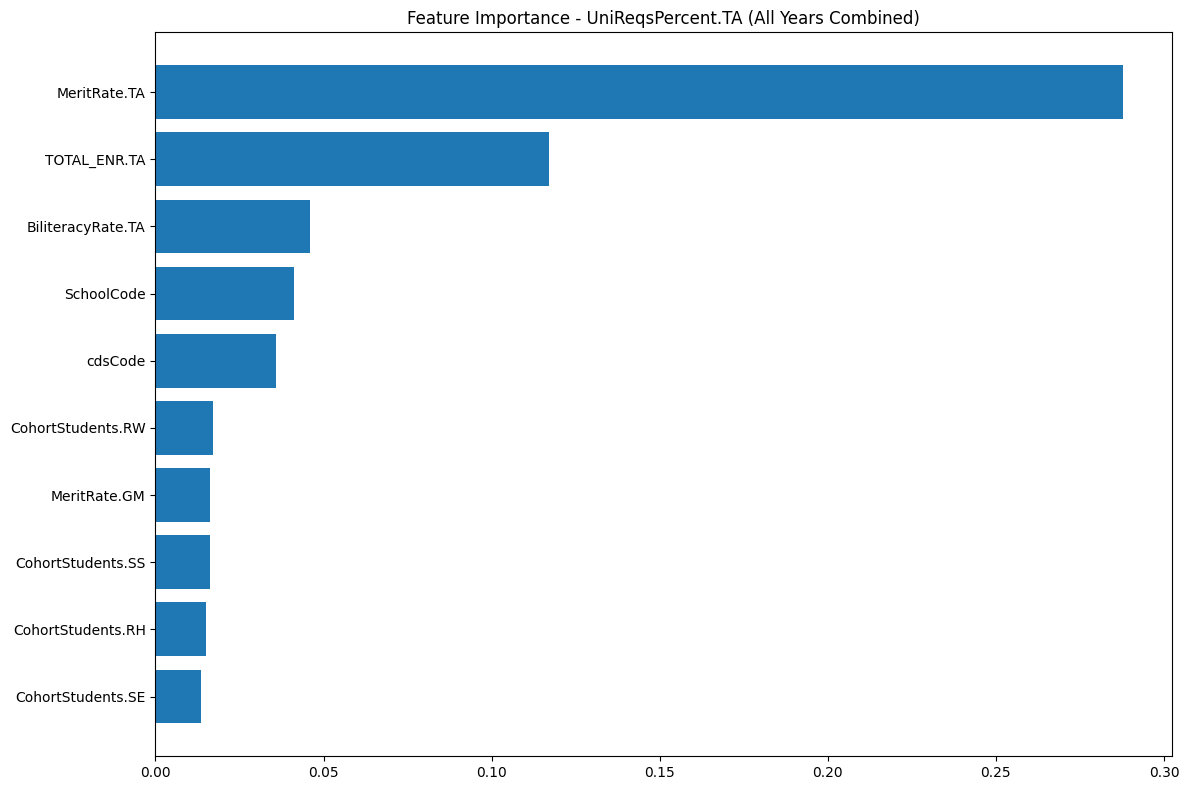

In [ ]:
# Part 3: Cross-validation for Random Forest on all data (not just year by year)

# Combine all data
all_years_df = pd.concat(year_df_mapping.values())

# Extract year as a numeric feature
all_years_df["Year"] = all_years_df["Year"].str.split("-").str[0].astype(int)
all_years_df["Year_Normalized"] = all_years_df["Year"] - all_years_df["Year"].min()

# Define targets
targets = ["RegHSDiplomaRate.TA", "UniReqsPercent.TA"]

# Run combined models for each target
for target_variable in targets:
    print(
        f"\nCross-validated Random Forest for {target_variable} (All Years Combined)\n"
    )

    # Fix the train_random_forest_model to cross_validate_random_forest
    cv_result = train_random_forest_model(
        df=all_years_df,
        target_column=target_variable,
        columns_to_drop=columns_to_drop + ["Year"],
        print_results=True,
        n_jobs=-1,
    )

    # Get feature importance for combined model
    importances = cv_result["model"].feature_importances_
    feature_names = cv_result["feature_names"]

    # Plot top features
    indices = np.argsort(importances)[-10:]
    plt.figure(figsize=(12, 8))
    plt.barh(range(10), importances[indices])
    plt.yticks(range(10), [feature_names[i] for i in indices])
    plt.title(f"Feature Importance - {target_variable} (All Years Combined)")
    plt.tight_layout()
    plt.show()


Modeling RegHSDiplomaRate.TA with Year Interactions

Top features for RegHSDiplomaRate.TA: ['GEDRate.GF', 'GEDRate.TA', 'SchoolCode', 'Merit.RW', 'TOTAL_ENR.GN_F']

Random Forest Regression Results for RegHSDiplomaRate.TA:
RMSE: 1.7032
MSE: 2.9009
R²: 0.9801

Importance of interaction terms:
  SchoolCode_x_Year: 0.017606
  TOTAL_ENR.GN_F_x_Year: 0.008714
  GEDRate.TA_x_Year: 0.004547
  GEDRate.GF_x_Year: 0.002876
  Merit.RW_x_Year: 0.001704


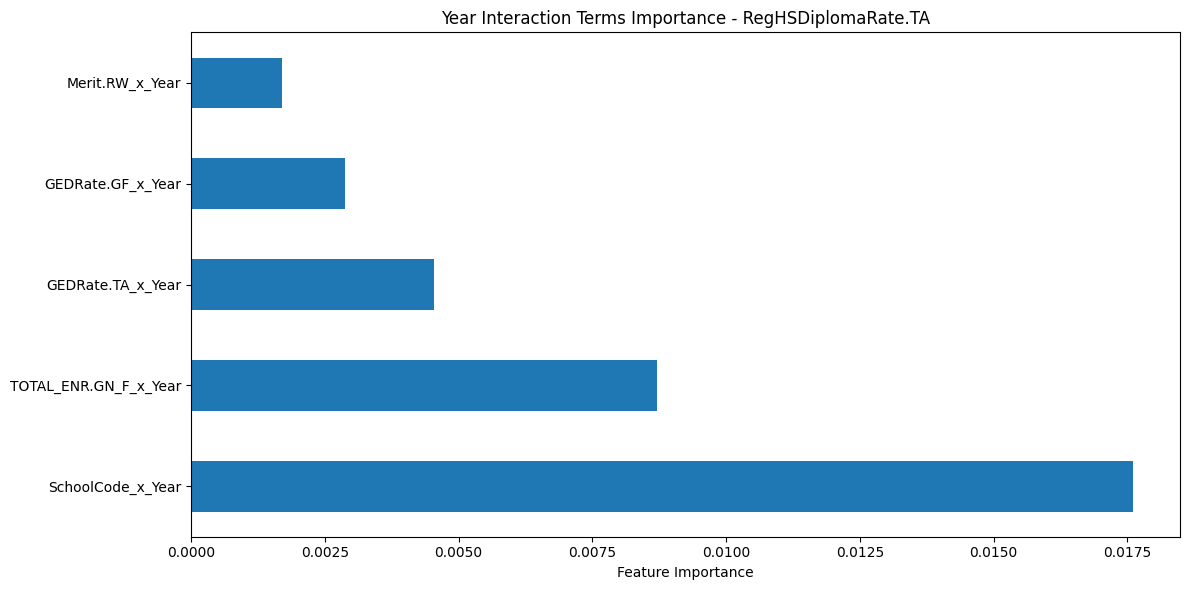


Modeling UniReqsPercent.TA with Year Interactions

Top features for UniReqsPercent.TA: ['MeritRate.TA', 'TOTAL_ENR.TA', 'BiliteracyRate.TA', 'SchoolCode', 'cdsCode']

Random Forest Regression Results for UniReqsPercent.TA:
RMSE: 2.7481
MSE: 7.5519
R²: 0.9852

Importance of interaction terms:
  SchoolCode_x_Year: 0.008899
  cdsCode_x_Year: 0.008622
  TOTAL_ENR.TA_x_Year: 0.005245
  MeritRate.TA_x_Year: 0.003754
  BiliteracyRate.TA_x_Year: 0.003109


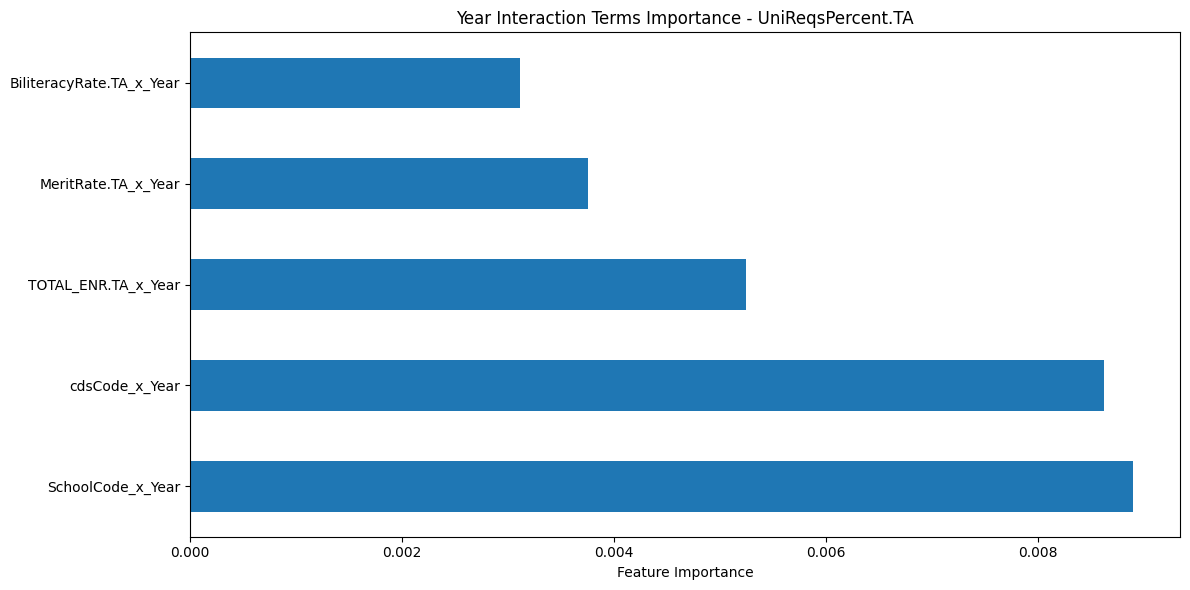

: 

In [ ]:
# Part 4: Include year interactions with top features

# First identify top features
def get_top_features(df, target, columns_to_drop, k=5):
    # Create a copy of the dataframe
    df_copy = df.copy()
    
    # Convert categorical columns to dummy variables
    for col in special_cols:
        df_copy[col] = (df_copy[col] == 'Y').astype(int)
    
    # Drop the specified columns
    X = df_copy.drop(
        columns=[target] + columns_to_drop,
        errors="ignore"
    )
    y = df_copy[target]
    
    # Make sure all columns are numeric
    X = X.select_dtypes(include=['number'])
    
    # Drop rows where y is NaN
    mask = ~y.isna()
    X = X.loc[mask]
    y = y.loc[mask]
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X, y)

    feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
    return feature_importances.sort_values(ascending=False).head(k).index.tolist()


# Dictionary to store results for each target
interaction_results = {}

for target_variable in targets:
    print(f"\nModeling {target_variable} with Year Interactions\n")

    # Get top features for this target
    top_features = get_top_features(all_years_df, target_variable, columns_to_drop)
    print(f"Top features for {target_variable}: {top_features}\n")

    # Create interaction terms
    interaction_df = all_years_df.copy()
    
    # Convert special columns to numeric
    for col in special_cols:
        interaction_df[col] = (interaction_df[col] == 'Y').astype(int)

    for feature in top_features:
        if feature in interaction_df.columns:
            interaction_df[f"{feature}_x_Year"] = (
                interaction_df[feature] * interaction_df["Year_Normalized"]
            )

    # Run cross-validation with interactions
    cv_interaction = train_random_forest_model(
        df=interaction_df,
        target_column=target_variable,
        columns_to_drop=columns_to_drop,
        print_results=True,
        n_jobs=-1,
    )

    interaction_results[target_variable] = cv_interaction

    # Analyze importance of interaction terms
    importances = cv_interaction["model"].feature_importances_
    feature_names = cv_interaction["feature_names"]

    # Identify interaction terms in feature importance
    interaction_indices = [
        i for i, name in enumerate(feature_names) if "_x_Year" in name
    ]

    if interaction_indices:
        interaction_importance = pd.Series(
            {feature_names[i]: importances[i] for i in interaction_indices}
        ).sort_values(ascending=False)

        print("\nImportance of interaction terms:")
        for term, importance in interaction_importance.items():
            print(f"  {term}: {importance:.6f}")

        # Plot interaction terms importance
        plt.figure(figsize=(12, 6))
        interaction_importance.plot(kind="barh")
        plt.title(f"Year Interaction Terms Importance - {target_variable}")
        plt.xlabel("Feature Importance")
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo interaction terms found in the feature list.")

In [ ]:
# Part 3 Modified: Cross-validation for Random Forest excluding COVID years
# Filter out COVID years
non_covid_years = ["2017-18", "2018-19", "2021-22", "2022-23", "2023-24"]
filtered_year_df_mapping = {year: year_df_mapping[year] for year in non_covid_years}

# Combine filtered data
filtered_years_df = pd.concat(filtered_year_df_mapping.values())

# Extract year as a numeric feature
filtered_years_df["Year"] = filtered_years_df["Year"].str.split("-").str[0].astype(int)
filtered_years_df["Year_Normalized"] = filtered_years_df["Year"] - filtered_years_df["Year"].min()

# Define targets
targets = ["RegHSDiplomaRate.TA", "UniReqsPercent.TA"]

# Run combined models for each target on filtered data
for target_variable in targets:
    print(
        f"\nCross-validated Random Forest for {target_variable} (Non-COVID Years Combined)\n"
    )

    cv_result = train_random_forest_model(
        df=filtered_years_df,
        target_column=target_variable,
        columns_to_drop=columns_to_drop + ["Year"],
        print_results=True,
        n_jobs=-1,
    )

    # Get feature importance for combined model
    importances = cv_result["model"].feature_importances_
    feature_names = cv_result["feature_names"]

    # Plot top features
    indices = np.argsort(importances)[-10:]
    plt.figure(figsize=(12, 8))
    plt.barh(range(10), importances[indices])
    plt.yticks(range(10), [feature_names[i] for i in indices])
    plt.title(f"Feature Importance - {target_variable} (Non-COVID Years Combined)")
    plt.tight_layout()
    plt.show()

In [ ]:
# Part 5: Year-by-Year Models and Longitudinal Visualization
# Run separate models for each year and track metrics
year_results = {}
target_variable = "RegHSDiplomaRate.TA"  # Change to "UniReqsPercent.TA" if needed

print(f"\nRunning year-by-year models for {target_variable}\n")

for year in non_covid_years:
    print(f"\nTraining model for {year}")
    year_df = year_df_mapping[year]
    
    # Convert special columns to numeric
    year_df_copy = year_df.copy()
    for col in special_cols:
        year_df_copy[col] = (year_df_copy[col] == 'Y').astype(int)
    
    # Train model
    results = train_random_forest_model(
        df=year_df_copy,
        target_column=target_variable,
        columns_to_drop=columns_to_drop,
        print_results=True,
        n_jobs=-1,
    )
    
    # Store results
    year_results[year] = {
        'model': results['model'],
        'feature_names': results['feature_names'],
        'metrics': results['metrics'],
    }

# Extract metrics for plotting
years = list(year_results.keys())
r2_scores = [year_results[year]['metrics']['r2'] for year in years]
rmse_scores = [year_results[year]['metrics']['rmse'] for year in years]

# Plot metrics over time
plt.figure(figsize=(14, 6))

# R² scores
plt.subplot(1, 2, 1)
plt.plot(years, r2_scores, marker='o', linestyle='-', linewidth=2)
plt.title(f'R² Over Time - {target_variable}')
plt.xlabel('Academic Year')
plt.ylabel('R²')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# RMSE scores
plt.subplot(1, 2, 2)
plt.plot(years, rmse_scores, marker='s', linestyle='-', color='orangered', linewidth=2)
plt.title(f'RMSE Over Time - {target_variable}')
plt.xlabel('Academic Year')
plt.ylabel('RMSE')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Feature importance over time
# Get top K features across all years
all_top_features = set()
for year in years:
    model = year_results[year]['model']
    feature_names = year_results[year]['feature_names']
    importances = model.feature_importances_
    top_indices = np.argsort(importances)[-5:]  # Top 5 features
    top_features = [feature_names[i] for i in top_indices]
    all_top_features.update(top_features)

# Track the importance of these features over time
feature_importance_over_time = {feature: [] for feature in all_top_features}

for year in years:
    model = year_results[year]['model']
    feature_names = year_results[year]['feature_names']
    importances = model.feature_importances_
    
    for feature in all_top_features:
        if feature in feature_names:
            idx = feature_names.index(feature)
            feature_importance_over_time[feature].append(importances[idx])
        else:
            feature_importance_over_time[feature].append(0)

# Plot top features over time
plt.figure(figsize=(14, 8))
markers = ['o', 's', '^', 'D', '*', 'p', 'h', 'v', '+', 'x']
for i, (feature, values) in enumerate(feature_importance_over_time.items()):
    plt.plot(years, values, marker=markers[i % len(markers)], linestyle='-', linewidth=2, label=feature)

plt.title(f'Feature Importance Over Time - {target_variable}')
plt.xlabel('Academic Year')
plt.ylabel('Feature Importance')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Part 6: Longitudinal Analysis of Year Interactions
# For each key feature, analyze how its effect changes over time
key_features_analysis = {}

for target_variable in targets:
    print(f"\nLongitudinal analysis of feature effects for {target_variable}\n")
    
    # Get top features
    top_features = get_top_features(filtered_years_df, target_variable, columns_to_drop, k=3)
    
    # For each feature, calculate its effect in each year
    for feature in top_features:
        print(f"Analyzing feature: {feature}")
        
        # Create bins based on feature values
        feature_values = {}
        feature_effects = {}
        
        for year in non_covid_years:
            year_df = year_df_mapping[year].copy()
            
            # Convert categorical values if needed
            if feature in special_cols:
                year_df[feature] = (year_df[feature] == 'Y').astype(int)
            
            # Create quartiles if numeric
            q1 = year_df[feature].quantile(0.25)
            q2 = year_df[feature].quantile(0.50)
            q3 = year_df[feature].quantile(0.75)
            
            # Group by binned feature and calculate mean target
            year_df['bin'] = pd.cut(year_df[feature], 
                                    bins=[-float('inf'), q1, q2, q3, float('inf')],
                                    labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
            
            effect = year_df.groupby('bin')[target_variable].mean()
            feature_values[year] = year_df[feature].mean()
            feature_effects[year] = effect
        
        # Plot the results
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[1, 3])
        
        # Plot 1: Average feature value over time
        ax1.plot(feature_values.keys(), feature_values.values(), marker='o', linestyle='-', color='blue')
        ax1.set_title(f'Average {feature} Value Over Time')
        ax1.set_ylabel(f'{feature} Value')
        ax1.grid(True, alpha=0.3)
        ax1.set_xticklabels(feature_values.keys(), rotation=45)
        
        # Plot 2: Effect of feature bins on target variable
        for bin_level in ['Low', 'Medium-Low', 'Medium-High', 'High']:
            bin_values = [feature_effects[year].get(bin_level, np.nan) for year in non_covid_years]
            ax2.plot(non_covid_years, bin_values, marker='o', linestyle='-', label=bin_level)
        
        ax2.set_title(f'Effect of {feature} on {target_variable} Over Time')
        ax2.set_xlabel('Academic Year')
        ax2.set_ylabel(f'{target_variable}')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_xticklabels(non_covid_years, rotation=45)
        
        plt.tight_layout()
        plt.show()

In [ ]:
con.close()